In [1]:
# Packages that need installing on startup

#!pip install ipywidgets

#if there are futher issues with librosa complaining about sndfile on import, run the following
#!apt-get -y update && apt-get -y install libsndfile1

In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd
import librosa as lb 
# Issue with installing librosa, using wavfile for visualization instead
#import ipywidgets as widgets

from scipy.io import wavfile
from sklearn.model_selection import StratifiedShuffleSplit
from pathlib import Path

import scipy

import tsfresh
import xlrd

# pip3 install shap

plt.rcParams['figure.figsize'] = [12, 8]

In [3]:
# Setup relative data paths, will need to be changed if running in deepnote

RAW_FOLDER = "../data/raw"
METADATA_FOLDER = "../data/metadata"
PROCESSED_FOLDER = "../data/processed"


In [4]:
df = pd.read_excel(f"{METADATA_FOLDER}/Age-sex calls- Dzanga Bai.xlsx",sheet_name="context", engine='openpyxl')
df.head()

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf


## Missingness by strata

In [5]:
n_records = len(df)
print(n_records)

valid_age = len(df[df.age != "un"]) / n_records 
valid_sex = len(df[df.sex != "un"]) / n_records 
valid_agsex = len(df[df.agsex != "un"]) / n_records 
print(f"Proportion of data available: \nAge: {valid_age}\nSex: {valid_sex}\nAgeSex: {valid_agsex}")

389
Proportion of data available: 
Age: 0.910025706940874
Sex: 0.8766066838046273
AgeSex: 0.8483290488431876


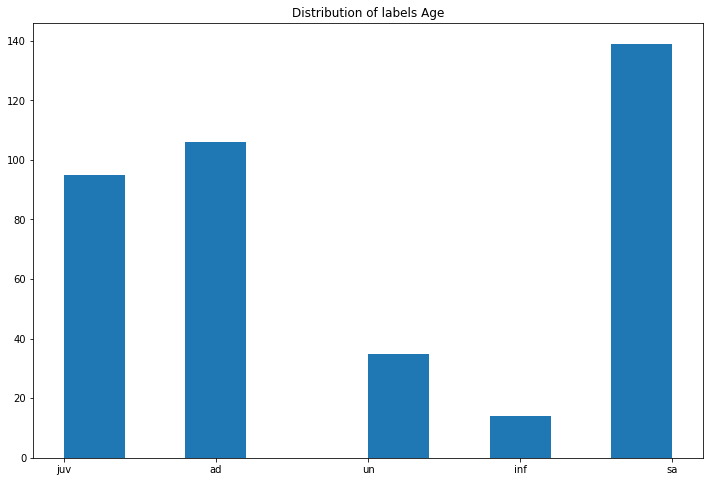

In [6]:
plt.hist(df.age)
plt.title("Distribution of labels Age")
plt.show()

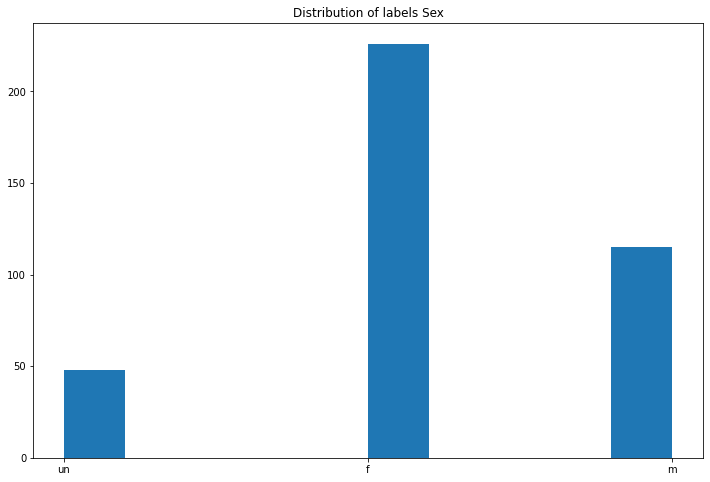

In [7]:
plt.hist(df.sex)
plt.title("Distribution of labels Sex")
plt.show()

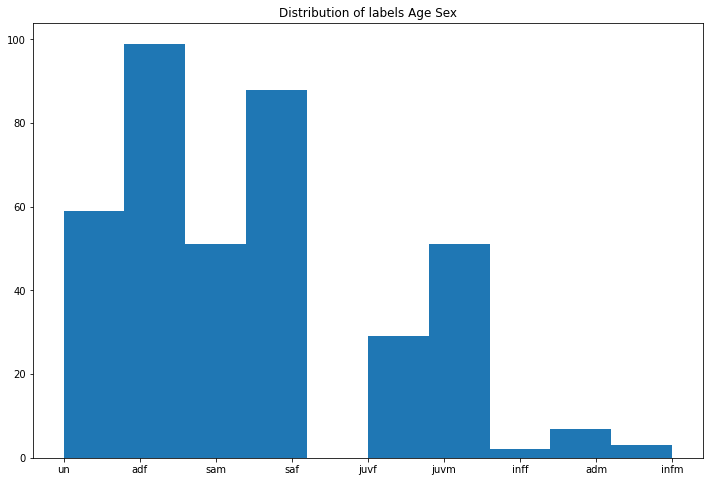

In [8]:
plt.hist(df.agsex)
plt.title("Distribution of labels Age Sex")
plt.show()

In [9]:
y = df.age.values
sss = StratifiedShuffleSplit(n_splits=1,test_size=0.3, random_state=42)

for train_idx, test_idx in sss.split(np.zeros(len(y)), y):
    y_train=y[train_idx]
    y_test=y[test_idx]

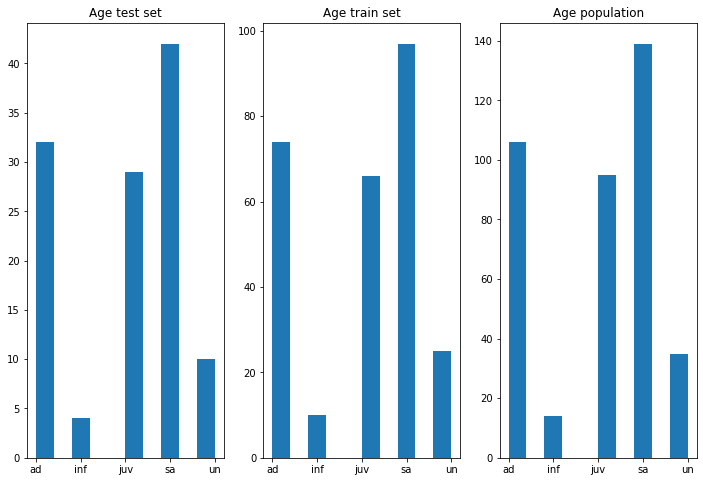

In [10]:
plt.subplot(1, 3, 1)
plt.title("Age test set")
plt.hist(sorted(y_test))
plt.subplot(1, 3, 2)
plt.title("Age train set")
plt.hist(sorted(y_train))
plt.subplot(1, 3, 3)
plt.title("Age population")
plt.hist(sorted(y))
plt.show()

## Creating spectograms

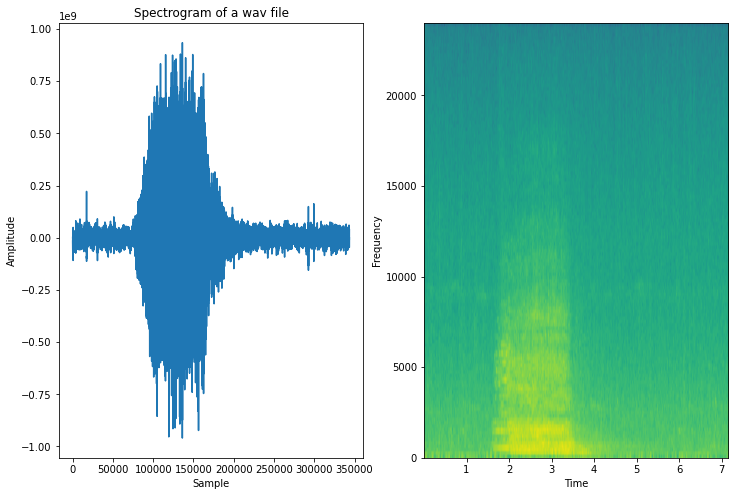

In [11]:
# Testing with a single wav file
audio_data = f'{RAW_FOLDER}/opp_329_ro.wav'
#
#ipd.Audio(audio_data,rate=60)

samplingFrequency, signalData = wavfile.read(audio_data)

# Plot the signal read from wav file

plt.subplot(121)
plt.title('Spectrogram of a wav file')
plt.plot(signalData)
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(122)
plt.specgram(signalData,Fs=samplingFrequency)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

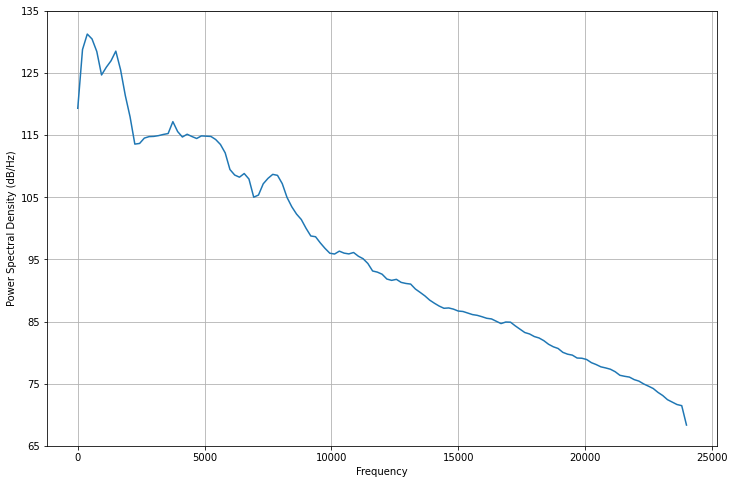

In [12]:
Density, freqs = plt.psd(signalData,Fs=samplingFrequency)

In [13]:
def spectral_statistics(y: np.ndarray, fs: int):
    """
    Compute mean frequency

    :param y: 1-d signal
    :param fs: sampling frequency [Hz]
    :return: mean frequency
    """
    spec = np.abs(np.fft.rfft(y))
    freq = np.fft.rfftfreq(len(y), d=1/fs)    
    amp = spec / spec.sum()
    mean = (freq * amp).sum()
    return mean 

In [14]:
def make_series(signalData, samplingFrequency, bin_value):
    freq_list = []
    time_list = []
    bin = bin_value
    for i in range(int(len(signalData)/samplingFrequency*bin)):
        freq_list.append(spectral_statistics(signalData[i*int(samplingFrequency/bin):(i+1)*int(samplingFrequency/bin)], samplingFrequency))
        time_list.append(i*(1/bin))
    return freq_list, time_list

In [15]:
bin_v = 50

In [16]:
freq_list, time_list = make_series(signalData, samplingFrequency, bin_v)

Text(0, 0.5, 'Frequency in Hz')

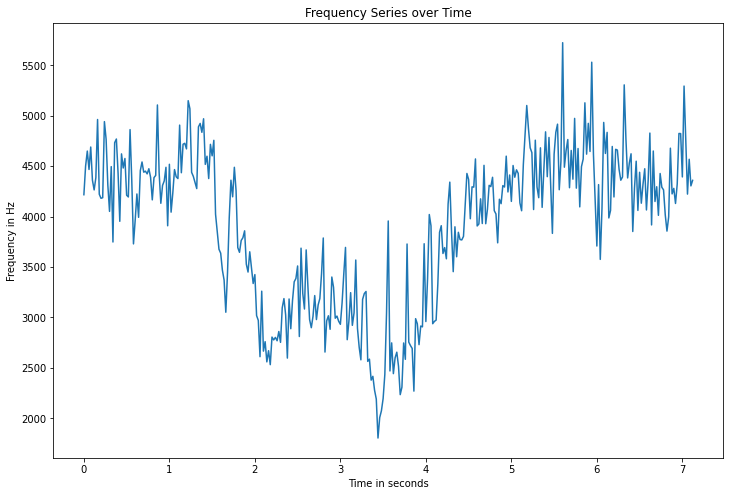

In [17]:
plt.plot(time_list, freq_list)
plt.title('Frequency Series over Time')
plt.xlabel('Time in seconds')
plt.ylabel('Frequency in Hz')

In [18]:
second_list = []
id_list = []
for i in range(len(time_list)):
    second_list.append(time_list[i])
    id_list.append('opp_329_ro.wav')

In [19]:
data = pd.DataFrame(list(zip(id_list, second_list, freq_list)), columns=["id","second", "frequency"])

data

# def smoothing(df):
#     lag_1 = df['signal'].shift(1)
#     lag_2 = df['signal'].shift(2)
#     lag_3 = df['signal'].shift(3)
#     lag_4 = df['signal'].shift(4)
#     lag_5 = df['signal'].shift(5)
#     lag_6 = df['signal'].shift(6)
#     lag_7 = df['signal'].shift(7)
#     lag_8 = df['signal'].shift(8)
#     lag_9 = df['signal'].shift(9)

#     df_new = pd.concat([df, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8, lag_9], axis=1)
#     column_name_list = ["id","count", "signal", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9"]
#     df_new.columns = column_name_list
#     df_new['avg'] = df_new[column_name_list[2:]].mean(axis=1)
#     df_new_return = df_new[['id', 'count', 'avg']]
#     df_new_rename = df_new_return.rename(columns={'avg': 'signal'})
#     return df_new_rename.iloc[::10, :]

# smoothed_df = smoothing(count_df)

# smoothed_df

# # lag_1 = count_df['signal'].shift(1)
# lag_2 = count_df['signal'].shift(2)
# lag_3 = count_df['signal'].shift(3)
# lag_4 = count_df['signal'].shift(4)
# lag_5 = count_df['signal'].shift(5)
# lag_6 = count_df['signal'].shift(6)
# lag_7 = count_df['signal'].shift(7)
# lag_8 = count_df['signal'].shift(8)
# lag_9 = count_df['signal'].shift(9)
# count_df_new=pd.concat([count_df, lag_1, lag_2, lag_3, lag_4, lag_5, lag_6, lag_7, lag_8, lag_9], axis=1)

# column_name_list = ["id","count", "signal", "lag_1", "lag_2", "lag_3", "lag_4", "lag_5", "lag_6", "lag_7", "lag_8", "lag_9"]
# count_df_new.columns = column_name_list
# count_df_new['avg'] = count_df_new[column_name_list[2:]].mean(axis=1)
# count_df_new

,id,second,frequency
0,opp_329_ro.wav,0.00,4216.626184
1,opp_329_ro.wav,0.02,4500.161370
2,opp_329_ro.wav,0.04,4649.292587
3,opp_329_ro.wav,0.06,4466.912234
4,opp_329_ro.wav,0.08,4689.342553
...,...,...,...
352,opp_329_ro.wav,7.04,4767.353783
353,opp_329_ro.wav,7.06,4222.759494
354,opp_329_ro.wav,7.08,4568.096111
355,opp_329_ro.wav,7.10,4304.255450


In [20]:
# --------------------------------------------------
# TSFresh Feature Extraction - takes about 15 mins
# --------------------------------------------------

extracted_features = tsfresh.extract_features(data, column_id="id", column_sort="second")

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00,  6.16it/s]


In [21]:
extracted_features

,frequency__variance_larger_than_standard_deviation,frequency__has_duplicate_max,frequency__has_duplicate_min,frequency__has_duplicate,frequency__sum_values,frequency__abs_energy,frequency__mean_abs_change,frequency__mean_change,frequency__mean_second_derivative_central,frequency__median,...,frequency__permutation_entropy__dimension_5__tau_1,frequency__permutation_entropy__dimension_6__tau_1,frequency__permutation_entropy__dimension_7__tau_1,frequency__query_similarity_count__query_None__threshold_0.0,"frequency__matrix_profile__feature_""min""__threshold_0.98","frequency__matrix_profile__feature_""max""__threshold_0.98","frequency__matrix_profile__feature_""mean""__threshold_0.98","frequency__matrix_profile__feature_""median""__threshold_0.98","frequency__matrix_profile__feature_""25""__threshold_0.98","frequency__matrix_profile__feature_""75""__threshold_0.98"
opp_329_ro.wav,1.0,0.0,0.0,0.0,1.396088e+06,5.665977e+09,316.916118,0.399507,-0.322451,4129.864416,...,4.602294,5.574569,5.8198,NaN,0.994273,3.110456,2.286366,2.302982,2.050996,2.567152


In [22]:
file_name_list = []
for dir_path, dir_names, file_names in os.walk('../data/raw'):
    file_name_list = file_names

In [23]:
name_list = []
for name in file_name_list:
    name_list.append(name[:-4])

In [24]:
def map_values(row, values_dict):
    return values_dict[row]

values_dict = {'juv': 0, 'inf': 0, 'ad': 1, 'sa': 1, 'un': ''}

df['age_label'] = df['age'].apply(map_values, args = (values_dict,))

In [25]:
df_data = df[df['age_label'] != '']

In [26]:
df_data = df_data.sort_values(by=['unique_ID'])

In [27]:
df_data

,unique_ID,call_type,comb,in_analysis,final_cat,final_subcat,distress,age,sex,agsex,age_label
0,opp_330_ru,ru,n,y,nrs,nrs,na,juv,un,un,0
1,opp_332_ru,ru,n,y,logistics,leave,na,ad,f,adf,1
2,opp_333_ru,ru,n,y,unspecific,unspecific,na,ad,f,adf,1
3,opp_333_ru1,ru,n,y,unspecific,unspecific,na,ad,f,adf,1
4,opp_333_ru2,ru,n,y,unspecific,unspecific,na,ad,f,adf,1
...,...,...,...,...,...,...,...,...,...,...,...
384,opp_876_ru2,ru,n,y,sep,sep,y,juv,m,juvm,0
385,opp_876_ru3,ru,n,y,sep,sep,y,juv,m,juvm,0
386,opp_878_ru,ru,n,y,af,af,na,ad,f,adf,1
387,opp_881_ru,ru,n,y,af,af,na,sa,f,saf,1


In [28]:
file_list=list(df_data['unique_ID'])

In [29]:
bin_v = 50
full_data_frame = pd.DataFrame(columns=['id', 'second', 'frequency'])
for name in file_list:
    audio_data = f'{RAW_FOLDER}/' + name + '.wav'
    samplingFrequency, signalData = wavfile.read(audio_data)
    freq_list, time_list = make_series(signalData, samplingFrequency, bin_v)
    second_list = []
    id_list = []
    for i in range(len(time_list)):
        second_list.append(time_list[i])
        id_list.append(name)
    data = pd.DataFrame(list(zip(id_list, second_list, freq_list)), columns=["id","second", "frequency"])
    full_data_frame = full_data_frame.append(data)

In [30]:
full_data_frame

,id,second,frequency
0,opp_330_ru,0.00,5368.467416
1,opp_330_ru,0.02,4901.004895
2,opp_330_ru,0.04,5037.667528
3,opp_330_ru,0.06,5092.083550
4,opp_330_ru,0.08,4173.712672
...,...,...,...
483,opp_881_ru1,9.66,3447.677713
484,opp_881_ru1,9.68,3251.078915
485,opp_881_ru1,9.70,2542.800229
486,opp_881_ru1,9.72,2293.113595


In [31]:
extracted_features = tsfresh.extract_features(full_data_frame, column_id="id", column_sort="second")

Feature Extraction: 100%|██████████| 40/40 [00:09<00:00,  4.07it/s]


In [32]:
final_features = extracted_features.sort_index()

In [33]:
final_features

,frequency__variance_larger_than_standard_deviation,frequency__has_duplicate_max,frequency__has_duplicate_min,frequency__has_duplicate,frequency__sum_values,frequency__abs_energy,frequency__mean_abs_change,frequency__mean_change,frequency__mean_second_derivative_central,frequency__median,...,frequency__permutation_entropy__dimension_5__tau_1,frequency__permutation_entropy__dimension_6__tau_1,frequency__permutation_entropy__dimension_7__tau_1,frequency__query_similarity_count__query_None__threshold_0.0,"frequency__matrix_profile__feature_""min""__threshold_0.98","frequency__matrix_profile__feature_""max""__threshold_0.98","frequency__matrix_profile__feature_""mean""__threshold_0.98","frequency__matrix_profile__feature_""median""__threshold_0.98","frequency__matrix_profile__feature_""25""__threshold_0.98","frequency__matrix_profile__feature_""75""__threshold_0.98"
opp_330_ru,1.0,0.0,0.0,0.0,1.076723e+06,3.844731e+09,746.618033,-11.752588,-2.093482,3215.808782,...,4.302554,5.257050,5.646447,NaN,0.944787,2.449175,1.591785,1.555067,1.382676,1.808031
opp_332_ru,1.0,0.0,0.0,0.0,2.668680e+06,1.566880e+10,489.729391,0.354038,0.684273,5779.849903,...,4.627609,5.738478,6.069113,NaN,0.681638,2.660051,1.794286,1.810608,1.611991,2.009122
opp_333_ru,1.0,0.0,0.0,0.0,2.270456e+06,1.182684e+10,534.190510,-1.299456,1.029169,5045.607602,...,4.592783,5.696419,6.055981,NaN,0.820097,2.613636,1.673551,1.713686,1.407606,1.932143
opp_333_ru1,1.0,0.0,0.0,0.0,1.198766e+06,4.309567e+09,556.685122,2.094077,-0.874495,3394.224082,...,4.533495,5.492425,5.804312,NaN,0.857502,2.554049,1.759430,1.785678,1.516461,2.022903
opp_333_ru2,1.0,0.0,0.0,0.0,1.342956e+06,5.392671e+09,647.789029,-3.949127,-2.374472,3293.011765,...,4.543161,5.541428,5.848088,NaN,0.992913,2.845790,1.835519,1.855308,1.587685,2.033484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
opp_876_ru2,1.0,0.0,0.0,0.0,5.334359e+05,1.307450e+09,1175.914274,0.557115,-6.352598,1953.556604,...,4.483076,5.297444,5.496029,NaN,0.725101,2.698529,1.846434,1.878983,1.626681,2.057259
opp_876_ru3,1.0,0.0,0.0,0.0,6.083837e+05,1.629045e+09,865.493388,-0.712439,-1.723803,2319.979126,...,4.422202,5.229662,5.481463,NaN,NaN,NaN,NaN,NaN,NaN,NaN
opp_878_ru,1.0,0.0,0.0,0.0,2.028225e+06,7.986588e+09,554.410558,-0.485177,2.326331,3705.524819,...,4.551168,5.706352,6.171200,NaN,0.789808,2.543762,1.656455,1.658756,1.422251,1.903860
opp_881_ru,1.0,0.0,0.0,0.0,2.137727e+06,8.402737e+09,731.232099,-5.593710,-1.103976,3575.526229,...,4.486765,5.694263,6.220371,NaN,1.039711,2.863552,2.003623,2.018615,1.762483,2.249293


In [34]:
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler

import umap
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap

In [35]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(final_features)
scaled_features = pd.DataFrame(scaled_features, columns=final_features.columns)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:765: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/extmath.py:706: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = op(x, *args, **kwargs)


In [36]:
scaled_features = scaled_features.fillna(0)

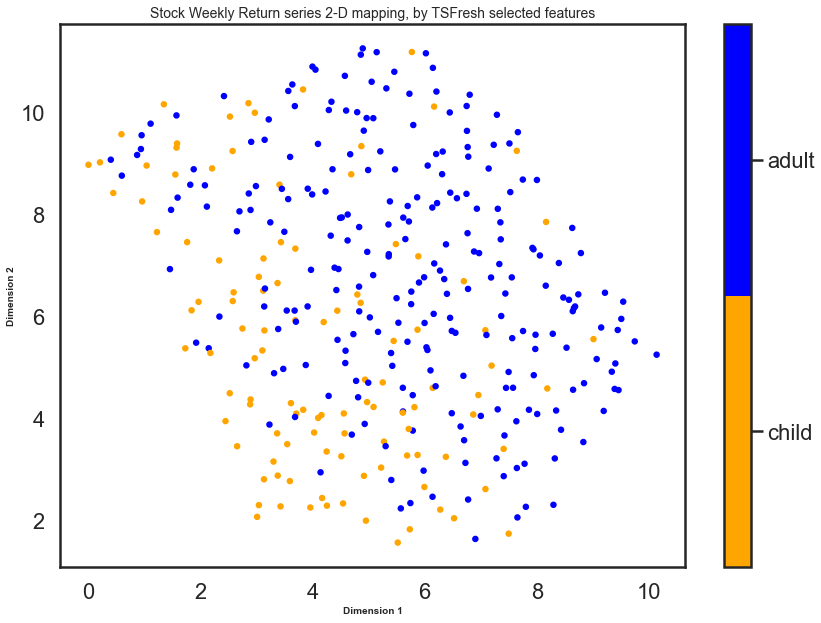

In [37]:
# UMAP of sparse word embeddings, by Year_Range:
y = df_data['age_label'].values

sns.set(style='white', context='poster')
cmap = LinearSegmentedColormap.from_list('mycmap', ['orange','blue'])
classes = ['child', 'adult']


embedding = umap.UMAP(n_neighbors=8, min_dist=0.8, n_components=2, metric='euclidean',
                      random_state=2021).fit_transform(scaled_features)
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*embedding.T, s=20, c=y, cmap=cmap, alpha=1.0)
cbar = plt.colorbar(boundaries=np.arange(2+1)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_ticklabels(classes)
plt.title('Stock Weekly Return series 2-D mapping, by TSFresh selected features').set_fontsize('14')
plt.xlabel('Dimension 1', weight='bold').set_fontsize('10')
plt.ylabel('Dimension 2', weight='bold').set_fontsize('10')
plt.plot()
plt.show()

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder,StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier,
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


In [39]:
scaled_features

,frequency__variance_larger_than_standard_deviation,frequency__has_duplicate_max,frequency__has_duplicate_min,frequency__has_duplicate,frequency__sum_values,frequency__abs_energy,frequency__mean_abs_change,frequency__mean_change,frequency__mean_second_derivative_central,frequency__median,...,frequency__permutation_entropy__dimension_5__tau_1,frequency__permutation_entropy__dimension_6__tau_1,frequency__permutation_entropy__dimension_7__tau_1,frequency__query_similarity_count__query_None__threshold_0.0,"frequency__matrix_profile__feature_""min""__threshold_0.98","frequency__matrix_profile__feature_""max""__threshold_0.98","frequency__matrix_profile__feature_""mean""__threshold_0.98","frequency__matrix_profile__feature_""median""__threshold_0.98","frequency__matrix_profile__feature_""25""__threshold_0.98","frequency__matrix_profile__feature_""75""__threshold_0.98"
0,0.0,0.0,0.0,0.0,-0.568935,-0.707205,1.319010,-2.574227,-1.151879,-0.827883,...,-1.527811,-0.607119,-0.214144,0.0,0.275647,-0.396063,-0.451961,-0.476112,-0.386954,-0.427240
1,0.0,0.0,0.0,0.0,2.271783,2.997147,-0.505330,0.150765,0.412990,1.960744,...,1.094791,1.168627,1.011040,0.0,-1.181335,-0.073794,-0.083452,-0.073208,-0.016310,-0.114758
2,0.0,0.0,0.0,0.0,1.561184,1.793503,-0.189581,-0.221408,0.607289,1.162189,...,0.813808,1.013491,0.972974,0.0,-0.414730,-0.144727,-0.303165,-0.226023,-0.346659,-0.234379
3,0.0,0.0,0.0,0.0,-0.351159,-0.561577,-0.029832,0.542418,-0.465153,-0.633840,...,0.335463,0.261060,0.243461,0.0,-0.207628,-0.235791,-0.146884,-0.112515,-0.170715,-0.093344
4,0.0,0.0,0.0,0.0,-0.093863,-0.222252,0.617158,-0.817803,-1.310176,-0.743918,...,0.413451,0.441809,0.370355,0.0,0.542107,0.210058,-0.008418,-0.002731,-0.055596,-0.076902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,0.0,0.0,0.0,0.0,-1.538385,-1.502107,4.367731,0.196474,-3.551282,-2.200696,...,-0.071324,-0.458124,-0.650161,0.0,-0.940695,-0.014990,0.011446,0.034596,0.007433,-0.039957
350,0.0,0.0,0.0,0.0,-1.404647,-1.401355,2.163224,-0.089281,-0.943617,-1.802179,...,-0.562473,-0.708139,-0.692385,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
351,0.0,0.0,0.0,0.0,1.128943,0.590394,-0.045985,-0.038128,1.338055,-0.295272,...,0.478058,1.050131,1.306960,0.0,-0.582428,-0.251511,-0.334276,-0.312629,-0.322988,-0.278328
352,0.0,0.0,0.0,0.0,1.324340,0.720769,1.209744,-1.187970,-0.594433,-0.436658,...,-0.041560,1.005541,1.449494,0.0,0.801214,0.237203,0.297496,0.254750,0.226931,0.258449


In [41]:
train_x, test_x, train_y, test_y = train_test_split(scaled_features.iloc[:, :], df_data['age_label'].values, test_size=0.30, random_state=100)

In [43]:
y = df_data['age_label'].values
y = y.astype('int')

In [44]:
train_y = train_y.astype('int')
test_y = test_y.astype('int')

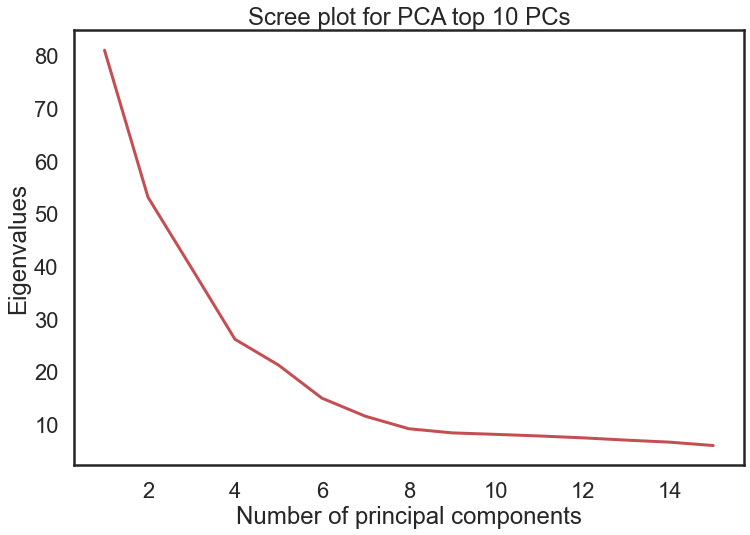

cumulative variance explained by top 10 PCA:  [0.11209969459918816, 0.18557796015224765, 0.2404784137989857, 0.2766543860918063, 0.30605292915638377, 0.32675730954466464, 0.3427087295457603, 0.35537343641304125, 0.3669507149637993, 0.3781400797010227, 0.388910642213392, 0.3991907468747174, 0.40886843330190337, 0.418014929847175, 0.42627128413489107] 2


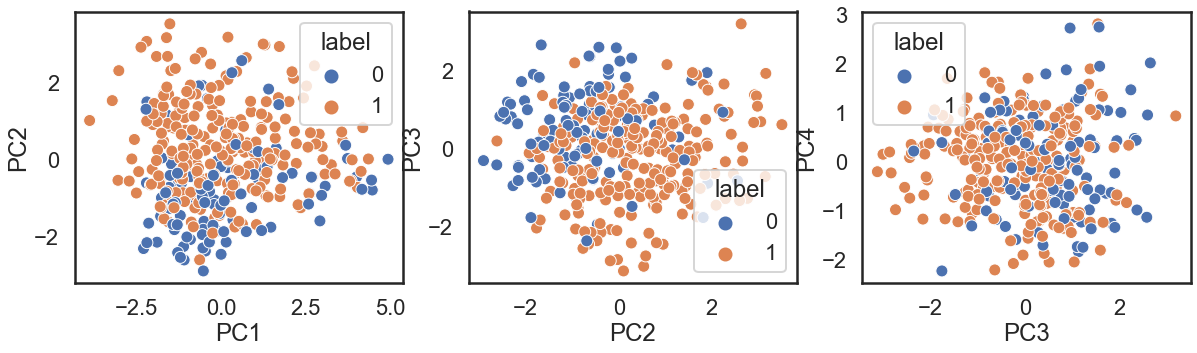

In [46]:
# ---------------------------
# PCA on filtered features
# ---------------------------
from sklearn.pipeline import Pipeline

pca = PCA(n_components = 15).fit(scaled_features)
eig = pca.explained_variance_
var_exp = pca.explained_variance_ratio_.cumsum()*100.

plt.plot(np.arange(1,len(eig)+1), eig, color='r')
plt.title('Scree plot for PCA top 10 PCs')
plt.xlabel('Number of principal components')
plt.ylabel('Eigenvalues')
plt.show()

# cumulative sum of PCA variance
cum_explained_var = []
for i in range(0, len(pca.explained_variance_ratio_)):
    if i == 0:
        cum_explained_var.append(pca.explained_variance_ratio_[i])
    else:
        cum_explained_var.append(pca.explained_variance_ratio_[i] + 
                                 cum_explained_var[i-1])

print("cumulative variance explained by top 10 PCA: ", cum_explained_var,2 )


# ----------
# project PC by decade
# ---------------
pipe = Pipeline([
        ('scaler', MinMaxScaler()),
        ('reducer', PCA(n_components=20))])

pca = pipe.fit_transform(scaled_features)

scaled_features_copy = scaled_features.copy()
scaled_features_copy['PC1'] = pca[:,0]
scaled_features_copy['PC2'] = pca[:,1]
scaled_features_copy['PC3'] = pca[:,2]
scaled_features_copy['PC4'] = pca[:,3]
scaled_features_copy['label'] = y


fig, axes = plt.subplots(1, 3, figsize = (20,5))
sns.scatterplot(data = scaled_features_copy, x = 'PC1', y = 'PC2', hue = 'label', ax = axes[0])
sns.scatterplot(data = scaled_features_copy, x = 'PC2', y = 'PC3', hue = 'label', ax = axes[1])
sns.scatterplot(data = scaled_features_copy, x = 'PC3', y = 'PC4', hue = 'label', ax = axes[2])


In [48]:
n_estimators =[75, 100, 125, 150]
min_samples_split= [2, 3]
max_features = ['auto', 0.1, 'sqrt']  
min_samples_leaf=[1, 2]
criterion = ['entropy', 'gini']


param_grid = {'n_estimators': n_estimators, 'min_samples_split': min_samples_split, 'max_features': max_features,
              'min_samples_leaf': min_samples_leaf, 'criterion': criterion}

model = RandomForestClassifier(random_state=100, class_weight='balanced')

grid_search = GridSearchCV(model, param_grid=param_grid, scoring="f1", verbose=2, cv=3)
grid_search.fit(scaled_features, y) 

print(grid_search.best_score_)
print(grid_search.best_params_)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.2s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.2s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.2s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.3s
[CV] crite

[CV]  criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=125 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=125, total=   0.3s
[CV] criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=125 
[CV]  criterion=entropy, max_features=auto, min_samples_leaf=2, min_samples_split=3, n_estimators=125, total=   0.3s
[CV] cr

[CV]  criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=100, total=   0.5s
[CV] criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125 
[CV]  criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.6s
[CV] criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125 
[CV]  criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.6s
[CV] criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125 
[CV]  criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.6s
[CV] criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=150 
[CV]  criterion=entropy, max_features=0.1, min_samples_leaf=2, min_samples_split=2, n_estimators=150, total=   0.7s
[CV] criterion=e

[CV]  criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=125, total=   0.3s
[CV] criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=125 
[CV]  criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=125, total=   0.3s
[CV] criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150 
[CV]  criterion=entropy, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=150, total=   0.4s
[CV] cr

[CV]  criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.3s
[CV] criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.3s
[CV] criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150 
[CV]  criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150, total=   0.3s
[CV] criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=75, total=   0.2s
[CV] criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=75 
[CV]  criterion=gini, max_features=auto, min_samples_leaf=1, min_samples_split=3, n_estimators=75, total=   0.2s
[CV] criterion=gini, max_features=auto

[CV]  criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.3s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.3s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=75 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=75, total=   0.3s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=1, min_samples_split=2, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_features=0.1, min_sampl

[CV]  criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=100, total=   0.4s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=125 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=125, total=   0.5s
[CV] criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=125 
[CV]  criterion=gini, max_features=0.1, min_samples_leaf=2, min_samples_split=3, n_estimators=125, total=   0.5s
[CV] criterion=gini, max_features=0.1, min_

[CV]  criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.3s
[CV] criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=125 
[CV]  criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.3s
[CV] criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=125 
[CV]  criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=125, total=   0.3s
[CV] criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150 
[CV]  criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150, total=   0.3s
[CV] criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150 
[CV]  criterion=gini, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150, total=   0.3s
[CV] criterion=gini, max_features=

[Parallel(n_jobs=1)]: Done 288 out of 288 | elapsed:  1.6min finished


0.8561687260375029
{'criterion': 'entropy', 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


In [49]:
# Concluded Random forest - TSfresh
args = {'random_state': 100, 'class_weight': 'balanced', 'oob_score': True,
        'criterion': 'entropy', 'max_features': 0.1, 'min_samples_leaf': 2, 'min_samples_split': 2, 
        'n_estimators': 100}

rf_clf = RandomForestClassifier(**args)
rf_clf.fit(train_x, train_y)

print('oob score:', rf_clf.oob_score_)


oob score: 0.805668016194332


In [50]:
y_actu = test_y
y_pred = rf_clf.predict(test_x)
confusion_matrix(y_actu, y_pred)


array([[19, 13],
       [12, 63]])

In [51]:
f1_score(y_actu, y_pred)

0.8344370860927153

In [30]:
def load_dz_data(base_data_dir, target_col="age"):
    """Load the Dzanga Bai data from the Excel spreadsheet into a dataframe.
    Also add the spectrogram path, rumble id, and age category columns.
    Additionally, remove any rumbles that are missing age.
    """
    df = pd.read_excel(
        os.path.join(base_data_dir, "Age-sex calls- Dzanga Bai.xlsx"),
        sheet_name="context",
    )
    # Create spectrogram paths in the dataframe.
    df["path"] = df["unique_ID"].apply(
        lambda x: os.path.join(base_data_dir, "spectrograms", f"{x}.png")
    )
    df["exists"] = df["path"].apply(lambda x: os.path.exists(x))
    df["rumble_id"] = df["unique_ID"].apply(lambda x: int(x.split("_")[1]))

    df["agecat"] = df["age"].apply(
        lambda x: "ad/sa"
        if x in ("ad", "sa")
        else "inf/juv"
        if x in ("inf", "juv")
        else "un"
    )
    df = df[df[target_col] != "un"]
    return df


def split_and_stratify_without_leakage(df, seed, split_sizes, stratify_col):
    """Split the data, stratifying by the given column.
    Ensure no data leaks by always adding rumbles with the same id to the same
    split.
    Return the indices for the splits as a tuple of numpy arrays.
    """
    n_splits = len(split_sizes)
    split_indices = [[] for _ in range(n_splits)]

    total_counts_by_target_col = df[stratify_col].value_counts()

    counts_by_target_col = [
        {target: 0 for target in df[stratify_col].unique()} for _ in range(n_splits)
    ]

    rumble_ids_with_indices = df["rumble_id"].reset_index()

    unique_rumble_ids = df["rumble_id"].unique()
    np.random.seed(seed)
    np.random.shuffle(unique_rumble_ids)

    for rumble_id in unique_rumble_ids:
        rumble_id_mask = rumble_ids_with_indices["rumble_id"] == rumble_id
        matching_rumble_indices = rumble_ids_with_indices[rumble_id_mask].index
        # Use the mode of the target column since some groups of rumble
        # ids have different age/sex values.
        # E.g. rumble id 368 has a rumble for "ad" and a rumble for "juv".
        target = df.iloc[matching_rumble_indices][stratify_col].mode()[0]

        # Find which set has the lowest ratio of that target (based on how
        # many it should have).
        ratios = [
            counts_by_target_col[i][target] / split_sizes[i] for i in range(n_splits)
        ]
        chosen_split = np.argmin(ratios)
        split_indices[chosen_split].extend(matching_rumble_indices)
        counts_by_target_col[chosen_split][target] += len(matching_rumble_indices)

    split_indices = tuple(map(np.array, split_indices))
    return split_indices


def output_csv(path, indices):
    """Output a csv with each index as its own line."""
    with open(path, "wt") as f:
        for index in indices:
            f.write(f"{index}\n")

In [45]:
_DEFAULT_PARAMS = {
    'BASE_DATA_DIR': '',
    # Stratify by the 4 category age column to make it more even.
    'STRATIFY_COL': 'age',
    'TEST_SIZE': 0.2,
    'OUTPUT_PATH': ''
}


class TestSplitter:
    """A class to split a dataset into cross validation folds and a test set.
    """

    def __init__(self, params=None):
        """Create a TestSplitter with the given params.
            BASE_DATA_DIR: The path to the directory with the Dzanga Bai data.
            STRATIFY_COL: The column to stratify the data on. The target
                column should be derived from this one.
            TEST_SIZE: The fraction of data to use for testing.
        """
        self._params = _DEFAULT_PARAMS.copy()
        if params is not None:
            self._params.update(params)

    def get_no_leakage_trainval_test_splits(self, save=True):
        """Split the Dzanga Bai data into training/validation and a test set.
        Stratify by STRATIFY_COL and ensure no data leaks by adding rumbles
        with the same id to the same split.
        Output the indices as separate csvs for training/validation and test.
        """
        df = load_dz_data(self._params['BASE_DATA_DIR'], target_col=self._params['STRATIFY_COL'])
        stratify_col = self._params['STRATIFY_COL']
        test_size = self._params['TEST_SIZE']
        seed = _DEFAULT_SEED_FOR_TRAIN_TEST_SPLIT
        split_sizes = [1 - test_size, test_size]
        
 
        train_val_indices, test_indices = (
            split_and_stratify_without_leakage(
                df, seed, split_sizes, stratify_col))
    
        if save:
            train_val_indices_filename = os.path.join(
                self._params[''], 'train_val_indices.csv')
            test_indices_filename = os.path.join(
                self._params[''], 'test_indices.csv')
            output_csv(train_val_indices_filename, train_val_indices)
            output_csv(test_indices_filename, test_indices)
        return train_val_indices, test_indices

In [46]:
from typing import Iterator, Optional, Tuple, List

def create_datasets(data_params: dict) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """ Handle the creation of train and test datasets
    Returns:
        Train Dataframe, Test Dataframe
    """
    target_col = data_params["STRATIFY_COL"]
    TestSplitter(data_params).get_no_leakage_trainval_test_splits()

    # Create folds
    train_val_indices = get_train_val_indices(data_params["OUTPUT_PATH"])
    CrossValidator(data_params).get_no_leakage_crossval_splits(train_val_indices)
    df = load_dz_data(data_params["BASE_DATA_DIR"], target_col=target_col)

    test_df = df[df.index.isin(get_test_indices(data_params["OUTPUT_PATH"]))]

    # Fastai Dataframes expect train and validation in the same dataframe
    train_val_df = df[df.index.isin(train_val_indices)].reset_index(drop=True)
    df_train = train_val_df[["path", target_col]]
    df_test = test_df[["path", target_col]]
    return df_train, df_test

In [47]:
data_params = {
                    "STRATIFY_COL": "age",
                    "NUM_K_FOLDS": 5,
                    "BASE_DATA_DIR": "./data/metadata",
                    "OUTPUT_PATH": "./data/metadata",
                    "SPECTROGRAM_DIR": "./data/metadata/spectrograms",
                    "SEED": 100,
                }

In [48]:
train_df, test_df = create_datasets(data_params)

FileNotFoundError: [Errno 2] No such file or directory: './data/metadata/Age-sex calls- Dzanga Bai.xlsx'

In [36]:
TestSplitter().get_no_leakage_trainval_test_splits()

FileNotFoundError: [Errno 2] No such file or directory: 'dzanga-bai-20210816T230919Z-001/dzanga-bai/Age-sex calls- Dzanga Bai.xlsx'

## Create feature space across sample set

We will create spectrograms and save to spectorgrams folder for use in CNN models


In [24]:

def wav_to_spectrogram(path):
    samplingFrequency, signalData = wavfile.read(path)
    plt.specgram(signalData,Fs=samplingFrequency)
    #plt.show()
    plt.savefig(f"{PROCESSED_FOLDER}/{path.stem}.png")


# Store all wav files as Path objects
wav_paths = sorted(Path(RAW_FOLDER).glob('*.wav'))

# Superceded by mel spectograms, dont run
#list(map(wav_to_spectrogram,wav_paths))

### TODO: Create Mel spectrograms to replace wav spectrograms using librosa

Only a fraction of the spectrograms are created as the machine timed out. Will have to create in batch

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

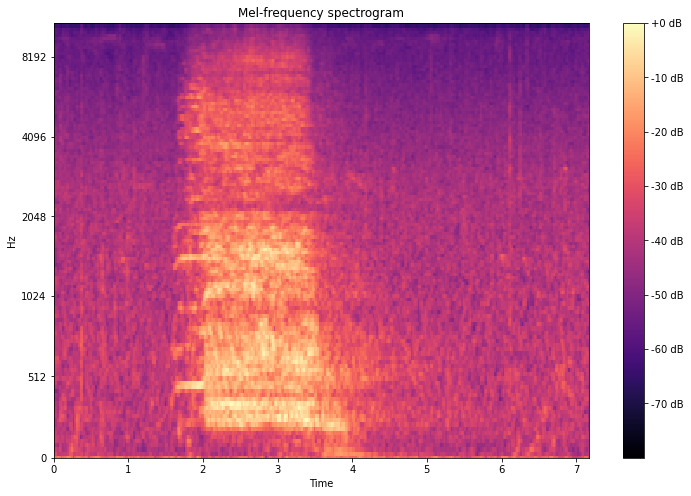

In [25]:
import librosa
import librosa.display
# Testing with a single wav file
audio_data = f'{RAW_FOLDER}/opp_329_ro.wav'
#
#ipd.Audio(audio_data,rate=60)

y, sr = librosa.load(audio_data)

# Passing through arguments to the Mel filters
S = librosa.feature.melspectrogram(y=y, sr=sr)#, n_mels=512,
                                   # fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+0.0f dB')
ax.set(title='Mel-frequency spectrogram')

S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=512)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+0.0f dB')
ax.set(title='Mel-frequency spectrogram')

Here we are exploring the features provided in the measurement tab of the metadata. We will look to see if there is any apparent structure to the data by performing a PCA.

In [29]:
features_df = pd.read_excel(f"{METADATA_FOLDER}/Age-sex calls- Dzanga Bai.xlsx", sheet_name="measurements")
features_df.head()

/home/karma/.local/share/virtualenvs/capstone_project-Bcy6YRu4/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,unique_ID,call_type,call,analysis,pfc_mean,pf_max,pf_min,pf_range,loc_pfc_max,loc_pfc_min,...,pf_en,loc_pf_en,loc_25_en,loc_50_en,loc_75_en,f1,form_space,total_dur,agg_entrop,avg_entro
0,opp_330_ru,ru,ru,f0,46.432141,52.73438,37.10938,15.62500,25.581395,95.348837,...,158.20312,0.7603,31.821445,50.125617,71.861821,158.13,NaN,2.2290,6.45124,5.54528
1,opp_332_ru,ru,ru,f0,28.325990,33.20312,18.55469,14.64843,9.883721,100.000000,...,32.22656,1.1722,21.280870,33.945099,52.941442,29.24,106.45,4.4298,5.74778,4.90156
2,opp_333_ru,ru,ru,for,22.968750,26.36719,16.60156,9.76563,30.666667,99.333333,...,26.36719,1.6079,39.191651,48.482719,61.755674,28.53,139.64,3.8424,4.46196,3.58849
3,opp_333_ru1,ru,ru,f0,25.500661,29.29688,17.57812,11.71876,11.267606,97.183099,...,29.29688,0.8288,17.779418,28.934274,46.363736,30.79,109.08,3.6576,5.26758,4.35843
4,opp_333_ru2,ru,ru,en,23.995535,26.36719,17.57812,8.78907,19.548872,100.000000,...,26.36719,1.1922,26.677396,40.108266,60.254572,25.88,100.11,3.4175,4.22392,3.60864


In [30]:
from sklearn.preprocessing import StandardScaler

# Separating out the features
# Removing text features, not clear what these are for
# call_type and call have 0 variance, analysis looks like truncated text
features_df.drop(["call_type","call","analysis"], axis=1, inplace=True)
features_df.reset_index(inplace=True)
features_df.dropna(inplace=True)
id_col = 'unique_ID'


x = features_df.loc[:, features_df.columns != id_col].values
# Separating out the target
y = features_df.loc[:,[id_col]].values
# Standardizing the features for use in PCA
x = StandardScaler().fit_transform(x)

In [31]:
x

array([[-1.72260133, -1.28248899, -1.14648827, ...,  0.82306649,
        -0.00743181, -0.03895846],
       [-1.7118764 , -1.79719586, -1.74614206, ...,  0.43615736,
        -1.46102607, -1.74243684],
       [-1.70115147, -1.55393774, -1.48914708, ...,  0.31443314,
        -0.55028848, -0.74357452],
       ...,
       [ 1.68792548,  1.54374629,  1.5947892 , ..., -1.42362799,
        -0.07521542,  0.76930088],
       [ 1.6986504 ,  0.9182461 ,  0.56681102, ..., -1.43344233,
        -1.43804341, -0.68293756],
       [ 1.70937533, -1.31295708, -1.14648827, ...,  1.01988032,
         0.2074725 , -0.1224024 ]])

Text(0, 0.5, 'cumulative explained variance')

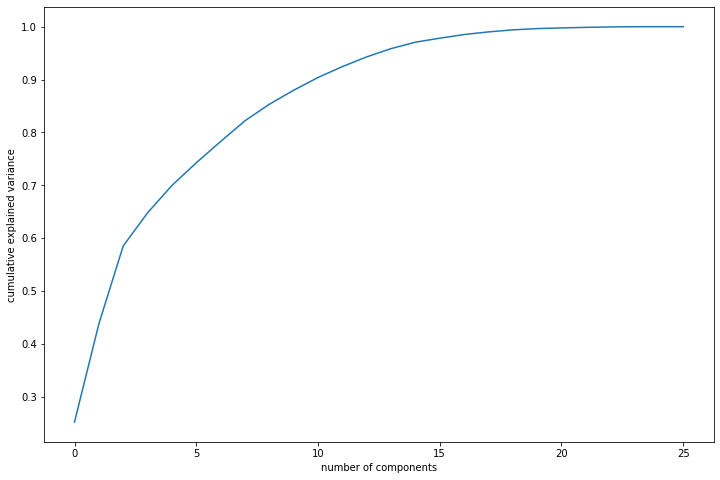

In [32]:
from sklearn.decomposition import PCA
pca = PCA().fit(x)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

Looks like we need about 9 principal components to account for around 90% of the variance using the provided features alone. Features may not be a good way to predict labels.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7aa10abb-09ba-4e5c-b109-d1b9cd39afe4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>